# All About LASSO

$$
\beta = \mbox{argmin}_{\beta} \|\mathbf{y} - A\beta\|_2^2 + \lambda \|\beta\|_1
$$

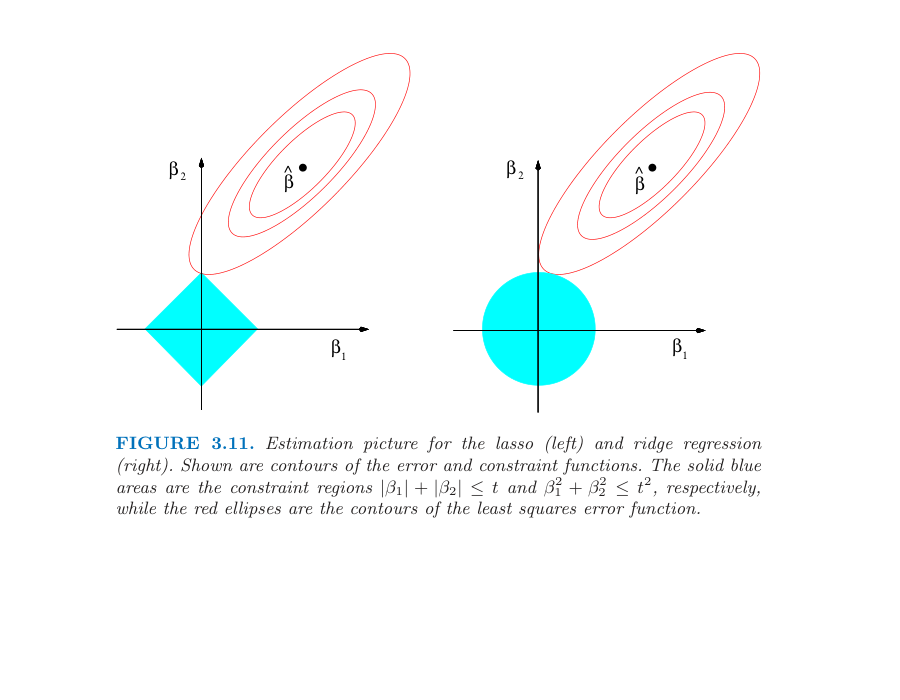

## A Note About Norms

Remember a while back when we talked about inner products. If $V$ is a vector space, an *inner product* $\langle, \rangle$ on $V$ satisfies

* $\langle v, 0 \rangle = 0$
* $\langle v + w, x \rangle = \langle v, x \rangle + \langle w, x \rangle$
* $\langle \lambda v, w \rangle = \lambda \langle v, w \rangle$

Not every vector space *has* an inner product, but every vector space has a dual vector space $V^\ast$ of *linear functionals*, which are functions $\phi: V \to \mathbb{R}$.

$V^\ast$ is a vector space:

* You can add two functionals $(\phi + \chi)(v) = \phi(v) + \chi(v)$.
* You can multiply by a scalar $(\lambda \phi)(v) = \lambda \phi(v)$
* There's a "zero" functional $\mathbf{0}(v) = 0$

If $V$ has a *norm*, then $V^\ast$ has a norm defined by:
$$
\|\phi\|_{V^\ast} = \max_{\{v : \|v\|_V \leq 1\}} |\phi(v)|
$$

For the $p$-norms that we looked at last time ($p \geq 1$):
$$
\|v\|_p = \left(\sum_{j=1}^p |v_j|^p\right)^{\frac{1}{p}}
$$
and
$$
\|v\|_\infty = \max_{j} |v_j|
$$

they are dual to each other with $q = \frac{p}{p-1}$. Note that $1$ and $\infty$ are paired and that $2$ is paired with itself.

In physics, they write stuff like
$$
A = |v\rangle \langle \phi |
$$

$$
Aw = v\langle \phi, w ⟩
$$


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
from scipy.signal import sawtooth
import statsmodels.api as sm

matplotlib.rcParams['figure.figsize'] = (20, 10)

## LASSO Computations

As noted last time, LASSO cannot be computed using matrix factorization, so we must use some variety of gradient descent, so let's start off by computing the gradient (with respect to $\beta$) of

$$
f(\beta) = \|\mathbf{y} - A\beta\|_2^2 + \lambda \|\beta\|_1
$$

$$
\frac{\partial f}{\partial \beta_j} = \begin{cases}
-2 \left(A_j \cdot (\mathbf{y} - A\beta) + \lambda \right)/ d & \mbox{ if $\beta_j > 0$} \\
-2 \left(A_j \cdot (\mathbf{y} - A\beta) - \lambda \right)/ d & \mbox{ if $\beta_j < 0$}
\end{cases}
$$

In [137]:
def linear_model(A, ys):
  u, s, vT = numpy.linalg.svd(A)
  u = u[:,:A.shape[1]]
  s_inv = numpy.diag(numpy.power(s, -1))
  uT = numpy.transpose(u)
  v = numpy.transpose(vT)
  pinv = numpy.dot(v, numpy.dot(s_inv, uT))
  coefs = numpy.dot(pinv, ys)
  return coefs

class LASSOModel():
  def __init__(self, lmbda, thresh, rate):
    self.lmbda = lmbda
    self.thresh = thresh
    self.rate = rate

  def fit(self, A, ys):
    rng = numpy.random.default_rng()
    self.N, self.d = A.shape
    self.beta = rng.normal(loc=0,scale=0.1, size=(self.d, 1))
    self.beta_previous = numpy.zeros(shape=(self.d, 1))
    while numpy.linalg.norm(self.beta - self.beta_previous) > self.thresh:
      self.beta_previous = self.beta
      self.beta = self._update_weights(A, ys)

    return LASSOModelResults(self.beta)

  def _update_weights(self, A, ys):
    pred = numpy.dot(A, self.beta)
    d_beta = numpy.zeros_like(self.beta)
    for j in range(self.d):
      if self.beta[j,0] > 0:
        d_beta[j,0] = (-2 * numpy.dot(A[:, j], (ys - pred)) + self.lmbda)/self.d
      else:
        d_beta[j,0] = (-2 * numpy.dot(A[:, j], (ys - pred)) - self.lmbda)/self.d

    return self.beta - self.rate*d_beta

class LASSOModelResults():
  def __init__(self,beta):
      self.beta = beta

  def predict(self,x):
    x = numpy.reshape((1,-1))
    return numpy.dot(x, self.beta)


def generate_collinear_data(range, noise_scale, size, seed):
  rng = numpy.random.default_rng(seed=seed)
  sample = rng.uniform(low=range[0], high=range[1], size=size)
  new_col = 3*sample[:,1] + 4*sample[:,3] - 2*sample[:,2] #+ rng.normal(loc=0, scale=0.01, size = sample.shape[0])
  new_col = numpy.reshape(new_col, (-1, 1))
  new_sample = numpy.hstack((sample, new_col))
  m = rng.integers(low=-10, high=10, size=(new_sample.shape[1], 1))
  ys = numpy.dot(new_sample, m)
  noise = rng.normal(loc=0, scale=noise_scale, size=ys.shape)
  return (new_sample, ys + noise)

def linear_data_generator(m, b, range, N, seed):
  rng = numpy.random.default_rng(seed=seed)
  sample = rng.uniform(low=range[0], high=range[1], size=(N, m.shape[0]))
  ys = numpy.dot(sample, numpy.reshape(m, (-1,1))) + b
  noise = rng.normal(loc=0., scale=50, size=ys.shape)
  return (sample, ys+noise)

## Let's Test!

In [159]:
A, ys = generate_collinear_data([-10, 10], 1, size=(100,10), seed=8675309)

In [160]:
model = LASSOModel(1000, 0.001, 0.000001)

In [161]:
linear_model(A, ys)

array([[ 9.96550093e-01],
       [-6.92826444e+13],
       [ 4.61884296e+13],
       [-9.23768592e+13],
       [-8.01491869e+00],
       [-6.00589979e+00],
       [ 6.02504464e+00],
       [ 4.02505935e+00],
       [ 3.05288289e+00],
       [-1.00817112e+00],
       [ 2.30942148e+13]])

In [162]:
result = model.fit(A, ys)

<ipython-input-137-4e93f6943f1a>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_beta[j,0] = (-2 * numpy.dot(A[:, j], (ys - pred)) - self.lmbda)/self.d
<ipython-input-137-4e93f6943f1a>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_beta[j,0] = (-2 * numpy.dot(A[:, j], (ys - pred)) + self.lmbda)/self.d


In [163]:
result.beta

array([[ 1.10123284],
       [ 3.09233535],
       [-0.89108114],
       [-1.02777003],
       [-6.80168025],
       [-4.90130023],
       [ 4.77536833],
       [ 2.65411432],
       [ 2.38093039],
       [-0.2690988 ],
       [ 7.17139474]])

In [144]:
preds = numpy.dot(A, result.beta)

In [146]:
errors = ys - preds

In [147]:
errors

array([[ 10.19797526],
       [-26.31563295],
       [  5.67049537],
       [  0.51887382],
       [ 12.5014256 ],
       [  9.55359608],
       [  9.06676963],
       [-15.95667131],
       [ -1.52209803],
       [ -4.10520565],
       [  0.97396395],
       [  5.93975703],
       [ 14.61653461],
       [ 12.07873853],
       [ 12.2568997 ],
       [ 14.61662842],
       [  3.15029386],
       [  5.24686984],
       [ -6.24434439],
       [  3.63230135],
       [  5.29381357],
       [ 14.64099715],
       [ 10.03072471],
       [ -7.95913713],
       [  6.0663249 ],
       [ 10.30540307],
       [-18.70986129],
       [ -9.07173917],
       [ -1.7941788 ],
       [-16.14866709],
       [-18.92522083],
       [ -8.06655586],
       [ -2.51626793],
       [  3.5483484 ],
       [ 15.93498781],
       [ -4.14715722],
       [  8.78452226],
       [ -0.82040766],
       [ -7.46184945],
       [-11.37746109],
       [-10.84722756],
       [ 23.20338193],
       [ 10.45840169],
       [-27

## Another Test

In [148]:
rng = numpy.random.default_rng(seed=8675)
m = rng.integers(low=-5, high=10, size=5)
A, ys = linear_data_generator(m, 0, [-10, 10], 100, seed=8675309)
print(m)

[-5  9 -4 -1  8]


In [149]:
model = LASSOModel(0.0001, 0.00001, 0.0000001)
result = model.fit(A, ys)

<ipython-input-137-4e93f6943f1a>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_beta[j,0] = (-2 * numpy.dot(A[:, j], (ys - pred)) + self.lmbda)/self.d
<ipython-input-137-4e93f6943f1a>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_beta[j,0] = (-2 * numpy.dot(A[:, j], (ys - pred)) - self.lmbda)/self.d


In [150]:
result.beta

array([[-5.85918929],
       [ 9.17254695],
       [-3.40540403],
       [-0.55866309],
       [ 7.75904387]])

In [151]:
preds = numpy.dot(A, result.beta)
errors = preds - ys

In [152]:
linear_model(A, ys)

array([[-5.82698944],
       [ 9.24140313],
       [-3.4051905 ],
       [-0.59830828],
       [ 7.80835719]])